# Example 4: Optimization for a perfect entangler

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

In [1]:
using DrWatson
@quickactivate "KrotovTests"

This example illustrates the optimization towards a perfectly entangling
two-qubit gate for a system of two transmon qubits with a shared transmission
line. It uses both the indirect perfect entanglers functional shown in
Goerz et. al., Phys. Rev. A 91, 062307 (2015) and a direct maximization of
the gate concurrence and thus demonstrates the optimization for non-analytic
functions via the calculation of gradients with automatic differentiation.

## Hamiltonian and guess pulses

We will write the Hamiltonian in units of GHz (angular frequency; the factor
2π is implicit) and ns:

In [2]:
const GHz = 2π
const MHz = 0.001GHz
const ns = 1.0
const μs = 1000ns;

The Hamiltonian and parameter are taken from Goerz et. al., Phys. Rev. A 91,
062307 (2015)., cf. Table 1 in that Reference.

In [3]:
⊗ = kron
const 𝕚 = 1im
const N = 6  # levels per transmon

using LinearAlgebra
using SparseArrays
using QuantumControl


function transmon_hamiltonian(;
    Ωre,
    Ωim,
    N=N,  # levels per transmon
    ω₁=4.380GHz,
    ω₂=4.614GHz,
    ωd=4.498GHz,
    α₁=-210MHz,
    α₂=-215MHz,
    J=-3MHz,
    λ=1.03,
    use_sparse=:auto
)
    𝟙 = SparseMatrixCSC{ComplexF64,Int64}(sparse(I, N, N))
    b̂₁ = spdiagm(1 => complex.(sqrt.(collect(1:N-1)))) ⊗ 𝟙
    b̂₂ = 𝟙 ⊗ spdiagm(1 => complex.(sqrt.(collect(1:N-1))))
    b̂₁⁺ = sparse(b̂₁')
    b̂₂⁺ = sparse(b̂₂')
    n̂₁ = sparse(b̂₁' * b̂₁)
    n̂₂ = sparse(b̂₂' * b̂₂)
    n̂₁² = sparse(n̂₁ * n̂₁)
    n̂₂² = sparse(n̂₂ * n̂₂)
    b̂₁⁺_b̂₂ = sparse(b̂₁' * b̂₂)
    b̂₁_b̂₂⁺ = sparse(b̂₁ * b̂₂')

    ω̃₁ = ω₁ - ωd
    ω̃₂ = ω₂ - ωd

    Ĥ₀ = sparse(
        (ω̃₁ - α₁ / 2) * n̂₁ +
        (α₁ / 2) * n̂₁² +
        (ω̃₂ - α₂ / 2) * n̂₂ +
        (α₂ / 2) * n̂₂² +
        J * (b̂₁⁺_b̂₂ + b̂₁_b̂₂⁺)
    )

    Ĥ₁re = (1 / 2) * (b̂₁ + b̂₁⁺ + λ * b̂₂ + λ * b̂₂⁺)
    Ĥ₁im = (𝕚 / 2) * (b̂₁⁺ - b̂₁ + λ * b̂₂⁺ - λ * b̂₂)

    if ((N < 5) && (use_sparse ≢ true)) || use_sparse ≡ false
        H = hamiltonian(Array(Ĥ₀), (Array(Ĥ₁re), Ωre), (Array(Ĥ₁im), Ωim))
    else
        H = hamiltonian(Ĥ₀, (Ĥ₁re, Ωre), (Ĥ₁im, Ωim))
    end
    return H

end;

We choose a pulse duration of 400 ns. The guess pulse amplitude is 35 MHz,
with a 15 ns switch-on/-off time. The Hamiltonian is written in a rotating
frame, so in general, the control field is allowed to be complex-valued. We
separate this into two control fields, one for the real part and one for the
imaginary part. Initially, the imaginary part is zero, corresponding to a
field exactly at the frequency of the rotating frame.

In [4]:
using QuantumControl.Shapes: flattop

function guess_pulses(; T=400ns, E₀=35MHz, dt=0.1ns, t_rise=15ns)

    tlist = collect(range(0, T, step=dt))
    Ωre = t -> E₀ * flattop(t, T=T, t_rise=t_rise)
    Ωim = t -> 0.0

    return tlist, Ωre, Ωim

end

tlist, Ωre_guess, Ωim_guess = guess_pulses();

We can visualize this:

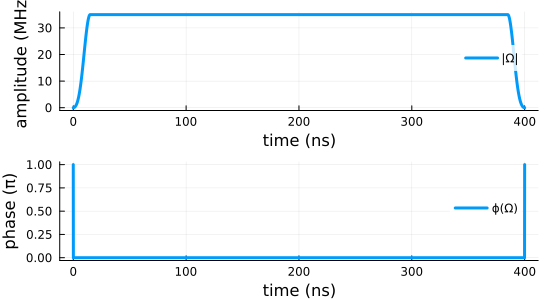

In [5]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8),
)

function plot_complex_pulse(tlist, Ω; time_unit=:ns, ampl_unit=:MHz, kwargs...)

    ax1 = plot(
        tlist ./ eval(time_unit),
        abs.(Ω) ./ eval(ampl_unit);
        label="|Ω|",
        xlabel="time ($time_unit)",
        ylabel="amplitude ($ampl_unit)",
        kwargs...
    )

    ax2 = plot(
        tlist ./ eval(time_unit),
        angle.(Ω) ./ π;
        label="ϕ(Ω)",
        xlabel="time ($time_unit)",
        ylabel="phase (π)"
    )

    plot(ax1, ax2, layout=(2, 1))

end

plot_complex_pulse(tlist, Ωre_guess.(tlist) + 𝕚 * Ωim_guess.(tlist))

## Logical basis for two-qubit gates

For simplicity, we will be define the qubits in the *bare* basis, i.e.
ignoring the static coupling $J$.

In [6]:
function ket(i::Int64; N=N)
    Ψ = zeros(ComplexF64, N)
    Ψ[i+1] = 1
    return Ψ
end

function ket(indices::Int64...; N=N)
    Ψ = ket(indices[1]; N=N)
    for i in indices[2:end]
        Ψ = Ψ ⊗ ket(i; N=N)
    end
    return Ψ
end

function ket(label::AbstractString; N=N)
    indices = [parse(Int64, digit) for digit in label]
    return ket(indices...; N=N)
end

basis = [ket("00"), ket("01"), ket("10"), ket("11")];

## Defining the optimization problem

We define the optimization with one objective for each of the four basis
states:

In [7]:
H = transmon_hamiltonian(Ωre=Ωre_guess, Ωim=Ωim_guess);

objectives = [Objective(; initial_state=Ψ, generator=H) for Ψ ∈ basis];

Note that we omit the `target_state` here. This is because we will be
optimizing for an arbitrary perfect entangler, not for a specific quantum
gate. Thus, there is no a-priori known target state to which the initial
state must evolve.

The optimization is steered by the perfect entanglers distance measure
$D_{PE}$, that is, the geometric distance of the quantum gate obtained from
propagating the four basis states to the polyhedron of perfect entanglers in
the Weyl chamber. Since the logical subspace defining the qubit is embedded
in the larger Hilbert space of the transmon, there may be loss of population
from the logical subspace. To counter this possibility in the optimization,
we add a unitarity measure  to $D_PE$. The two terms are added with equal
weight.

In [8]:
using QuantumControl.WeylChamber: D_PE, gate_concurrence, unitarity
using QuantumControl.Functionals: gate_functional

J_T_PE = gate_functional(D_PE; unitarity_weight=0.5);

The `gate_functional` routines used above converts the function `D_PE` that
receives the gate $Û$ as a 4×4 matrix into a functional of the correct from
for the `QuantumControl.optimize` routine, which is a function of the
propagated states.

We can check that for the guess pulse, we are not implementing a perfect
entangler

In [9]:
using QuantumControl: propagate_objectives

guess_states = propagate_objectives(objectives, tlist; use_threads=true);

U_guess = [basis[i] ⋅ guess_states[j] for i = 1:4, j = 1:4]

gate_concurrence(U_guess)

0.7773116198517142

We find that the guess pulse produces a gate in the `W0*` region of the Weyl
chamber:

In [10]:
using QuantumControl.WeylChamber: weyl_chamber_region
weyl_chamber_region(U_guess)

"W0*"

That is, the region of the Weyl chamber containing controlled-phase gates with
a phase $> π$ (Weyl chamber coordinates $c₁ > π/2$, $c₂ < π/4$).

This in fact allows use to use the perfect entangler functional without
modification: if the guess pulse were in the "W1" region of the Weyl chamber,
(close to SWAP), we would have to flip its sign, or we would optimize towards
the local equivalence class of the SWAP gate instead of towards the perfect
of perfect entanglers. In principle, we could use a modified functional that
takes the absolute square of the `D_PE` term, by using

```
J_T_PE = gate_functional(D_PE; unitarity_weight=0.5, absolute_square=true)
```

This would specifically optimize for the *surface* of the perfect
entanglers functional.

The guess pulse loses about 10% of population from the logical subspace:

In [11]:
1 - unitarity(U_guess)

0.09071664593714401

We can also evaluate the geometric distance to the polyhedron of perfect
entanglers in the Weyl chamber:

In [12]:
D_PE(U_guess)

0.7787454222375886

Together with the unitarity measure, this is the initial value of the
optimization functional:

In [13]:
0.5 * D_PE(U_guess) + 0.5 * (1 - unitarity(U_guess))

0.4347310340873663

In [14]:
J_T_PE(guess_states, objectives)

0.4347310340873663

## Optimization

Now, we formulate the full control problem

In [15]:
problem = ControlProblem(
    objectives=objectives,
    lambda_a=10.0,
    update_shape=(t -> flattop(t, T=400ns, t_rise=15ns, func=:blackman)),
    tlist=tlist,
    iter_stop=100,
    J_T=J_T_PE,
    check_convergence=res -> begin
        (
            (res.J_T > res.J_T_prev) &&
            (res.converged = true) &&
            (res.message = "Loss of monotonic convergence")
        )
        (
            (res.J_T <= 1e-3) &&
            (res.converged = true) &&
            (res.message = "Found a perfect entangler")
        )
    end,
    use_threads=true,
);

Note that we have not not given a `chi` parameter to calculate the boundary
condition $|χₖ⟩ = -∂J_T/∂⟨ϕₖ|$ that Krotov's method requires. In this case,
the Krotov.jl package will use automatic differentiation to determine the
derivative. In principle, the perfect entanglers function has an analytical
derivative, but it is exceedingly laborious to calculate and implement it
(see the [source code of the `weylchamber` Python
package](https://github.com/qucontrol/weylchamber/blob/master/src/weylchamber/perfect_entanglers.py),
which can evaluate that derivative).

In [16]:
opt_result = @optimize_or_load(datadir("PE_OCT.jld2"), problem; method=:Krotov);

In [17]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2022-10-28T20:39:44.344
- Number of objectives: 4
- Number of iterations: 27
- Value of functional: 5.44530e-04
- Reason for termination: Found a perfect entangler
- Ended at 2022-10-28T20:40:15.753 (31 seconds, 409 milliseconds)


## Optimization result

We extract the optimized control field from the optimization result and plot
it

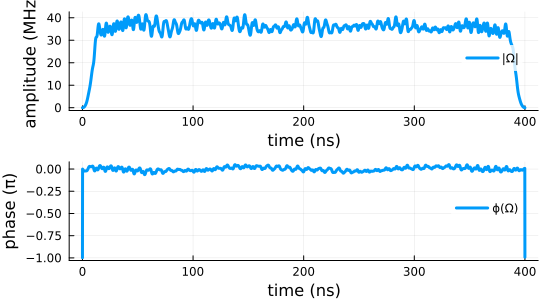

In [18]:
Ω_opt = opt_result.optimized_controls[1] + 𝕚 * opt_result.optimized_controls[2]

plot_complex_pulse(tlist, Ω_opt)

We then propagate the optimized control field to analyze the resulting
quantum gate:

In [19]:
using QuantumControl.Controls: substitute, get_controls

opt_states = propagate_objectives(
    substitute(
        objectives,
        IdDict(zip(get_controls(objectives), opt_result.optimized_controls))
    ),
    tlist;
    use_threads=true
);

U_opt = [basis[i] ⋅ opt_states[j] for i = 1:4, j = 1:4];

We find that we have achieved a perfect entangler:

In [20]:
gate_concurrence(U_opt)

1.0

Moreover, we have reduced the population loss to ≈ 1%

In [21]:
1 - unitarity(U_opt)

0.009864163148741056

## Direct maximization of the gate concurrence

In the previous optimizations, we have optimized for a perfect entangler
indirectly via a geometric function in the Weyl chamber. The entire reason
that perfect entangler functional was formulated is because calculating the
gate concurrence directly involves the eigenvalues of the unitary, see
Kraus, Cirac, Phys. Rev. A 63, 062309 (2001) and
Childs et al., PRA 68, 052311 (2003), which are inherently non-analytic.

However, since Krotov.jl can use automatic differentiation, this is no longer
an insurmountable obstacle!

We can define a functional for a given gate `U` that combines the gate
concurrence and (as above) a unitarity measure to penalize loss of population
from the logical subspace:

In [22]:
J_T_C = U -> 0.5 * (1 - gate_concurrence(U)) + 0.5 * (1 - unitarity(U));

In the optimization, we will convert this functional to one that takes the
propagated states as arguments (via the `gate_functional` routine).
We can do that same for the gradient: Let Zygote (the automatic
differentiation framework we are using) determine the gradient for `J_T_C`
with respect to `U`, but then analytically translate that into the derivative
with respect to the states that we need to calculate the χ-states.

In [23]:
using QuantumControl.Functionals: make_gate_chi

chi_C = make_gate_chi(J_T_C, objectives);

Running this, we again are able to find a perfect entangler.

In [24]:
opt_result_direct = @optimize_or_load(
    datadir("PE_OCT_direct.jld2"),
    problem;
    method=:Krotov,
    J_T=gate_functional(J_T_C),
    chi=chi_C
);

In [25]:
opt_result_direct

Krotov Optimization Result
--------------------------
- Started at 2022-10-28T20:40:23.247
- Number of objectives: 4
- Number of iterations: 65
- Value of functional: 9.70036e-04
- Reason for termination: Found a perfect entangler
- Ended at 2022-10-28T20:40:40.001 (16 seconds, 754 milliseconds)


In [26]:
opt_states_direct = propagate_objectives(
    substitute(
        objectives,
        IdDict(zip(get_controls(objectives), opt_result_direct.optimized_controls))
    ),
    tlist;
    use_threads=true
);

U_opt_direct = [basis[i] ⋅ opt_states_direct[j] for i = 1:4, j = 1:4];

In [27]:
gate_concurrence(U_opt_direct)

0.9999116674541454

In [28]:
1 - unitarity(U_opt_direct)

0.001851739389755136

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*